# Sentiment analysis on tweets from Stocktwit
## Import libraries and configurations

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install nltk==3.5
    !pip install scikit-plot
    !pip install seaborn
    !pip install wordcloud
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
import wordcloud

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [9]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [10]:
if IN_COLAB:
    tweet_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    tweet_dir = './data/tweet/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

In [15]:
def load_tweet(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    with open(tweet_dir + filename, 'r') as f:
        twits = json.load(f)

    df = pd.DataFrame(twits['data'])
    messages = [twit['message_body'] for twit in twits['data']]
    # Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in the network
    sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
    print("The number of twits is: ", len(twits['data']))
    return messages, sentiments, df

In [16]:
# Load data
filename = 'twits.json'
messages, sentiments, df = load_tweet(filename)

The number of twits is:  1548010


In [18]:
pd.set_option('display.max_colwidth', -1)
df.head(20)

,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z
2,#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy http://www.stocktargetadvisor.com/toprating,2,2018-07-01T00:01:24Z
3,$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.,1,2018-07-01T00:01:47Z
4,$AMD reveal yourself!,0,2018-07-01T00:02:13Z
5,$AAPL Why the drop? I warren Buffet taking out his position?,1,2018-07-01T00:03:10Z
6,$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA,-2,2018-07-01T00:04:09Z
7,"$BAC ok good we&#39;re not dropping in price over the weekend, lol",1,2018-07-01T00:04:17Z
8,"$AMAT - Daily Chart, we need to get back to above 50.",2,2018-07-01T00:08:01Z
9,"$GME 3% drop per week after spike... if no news in 3 months, back to 12s... if BO, then bingo... what is the odds?",-2,2018-07-01T00:09:03Z


## Check the statistics of texts

The total number of data:  1548010


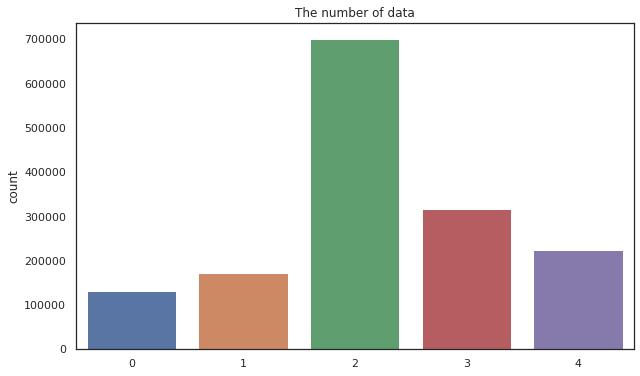

In [13]:
print("The total number of data: ", len(sentiments))
plt.figure(figsize=(10,6))
sns.countplot(x=sentiments)
plt.title('The number of data')
plt.show()

## Preprocess Messages

In [14]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    return text

In [15]:
# Check
test_message = 'RT @google Our annual looked at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG'
print(preprocess(test_message))


rt   our annual looked at the year in google blogging  and beyond     


In [16]:
preprocessed = [preprocess(message) for message in tqdm(messages)]

## Explore the text

In [17]:
all_words = [word for message in preprocessed for word in message.split()]
print('The number of all words: ', len(all_words))

counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])

The number of all words:  16553561
The number of unique words:  105899
Top 40 frequent words:  ['the', 'to', 'is', 'a', 'for', 'on', 'of', 'and', 'in', 'this', 's', 'i', 'it', 'at', 'will', 'up', 'are', 'you', 'that', 'be', 'q', 'what', 'today', 't', 'here', 'just', 'buy', 'down', 'with', 'short', 'not', 'we', 'from', 'all', 'if', 'now', 'out', 'they', 'more', 'was']


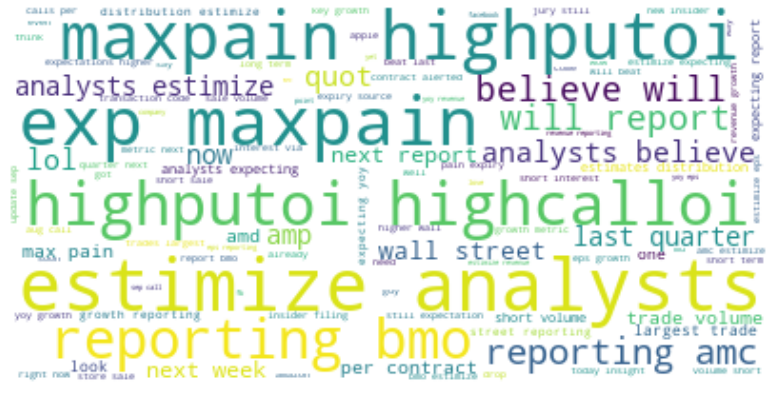

In [18]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(all_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=None, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
preprocessed[:2]

['  great buy at         ill wait', '   ']

## Filtering

In [20]:
tmp_dict = {'org message': messages, 'sentence': preprocessed, 'label': sentiments}
tmp_df = pd.DataFrame(tmp_dict)
tmp_df = tmp_df.loc[tmp_df['sentence'].apply(lambda x: len(x.split())) >= 10]
tmp_df.reset_index(drop=True, inplace=True)
tmp_df

,org message,sentence,label
0,#STAAnalystAlert for $TDG : Jefferies Maintain...,staanalystalert for jefferies maintains w...,4
1,$AMD I heard there’s a guy who knows someone w...,i heard there s a guy who knows someone who ...,3
2,$AAPL Why the drop? I warren Buffet taking out...,why the drop i warren buffet taking out his...,3
3,$BAC ok good we&#39;re not dropping in price o...,ok good we re not dropping in price over...,3
4,$GME 3% drop per week after spike... if no new...,drop per week after spike if no news i...,0
5,$SNPS short ratio is 2.17 at 2018-06-15 and sh...,short ratio is at and short ...,0
6,"$NFLX price squeezing,perfect place for an opt...",price squeezing perfect place for an option ...,4
7,@DEEPAKM2013 @Nytunes Start of new Q on Monday...,start of new q on monday expect strong bu...,4
8,$AMZN 3 catalysts 4 Continuing this new uptren...,catalysts continuing this new uptrend ...,4
9,$AAPL has moved -0.21% on 06-29. Check out the...,has moved on check out the mov...,2


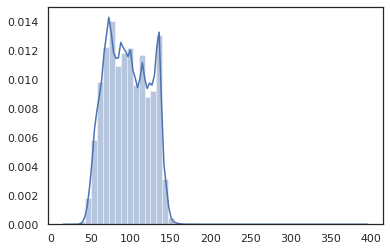

In [21]:
sns.distplot([len(x) for x in tmp_df['sentence']])


Somehow CUDA in Colab encounters runtime error to process. Here, just use label = 0, 2, 4 and balance the data.

In [28]:
# Take 0, 2, 4 and update them to 0, 1, 2
train_df = tmp_df.loc[(tmp_df['label']==int(0))|(tmp_df['label']==int(2))|(tmp_df['label']==int(4))]
def update_label(x):
    if x == int(2):
        return int(1)
    elif x == int(4):
        return int(2)
    else:
        return int(0)
train_df['label'] = train_df['label'].apply(lambda x: update_label(x))

# Balancing the data
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = train_df.shape[0]

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)

balanced = {'org message': [], 'sentence': [], 'label': []}

# Keep probability
# As the negative has the least number of data, trim neutral and positive
keep_prob_neutral = n_negative/n_neutral
keep_prob_positive = n_negative/n_positive
#keep_prob = 1

for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    if row['sentence'].strip() == "":
        continue
    elif (row['label'] == 0) or ((row['label'] == 1) and (random.random() < keep_prob_neutral)) or ((row['label'] == 2) and (random.random() < keep_prob_positive)):
        balanced['org message'].append(row['org message'])
        balanced['sentence'].append(row['sentence'])
        balanced['label'].append(row['label'])

train_df = pd.DataFrame(balanced)
n_negative = sum(1 for each in train_df['label'] if each == 0)
n_neutral = sum(1 for each in train_df['label'] if each == 1)
n_positive = sum(1 for each in train_df['label'] if each == 2)
N_examples = len(train_df)

print('Negative:', n_negative/N_examples)
print('Neutral: ', n_neutral/N_examples)
print('Positive:', n_positive/N_examples)
print('Total records: ', N_examples)


Negative: 0.14340164994682228
Neutral:  0.6166585223298552
Positive: 0.2399398277233225
Total records:  521835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



Negative: 0.33368858051253697
Neutral:  0.3319673410417512
Positive: 0.33434407844571185
Total records:  224257


The total number of data:  224257


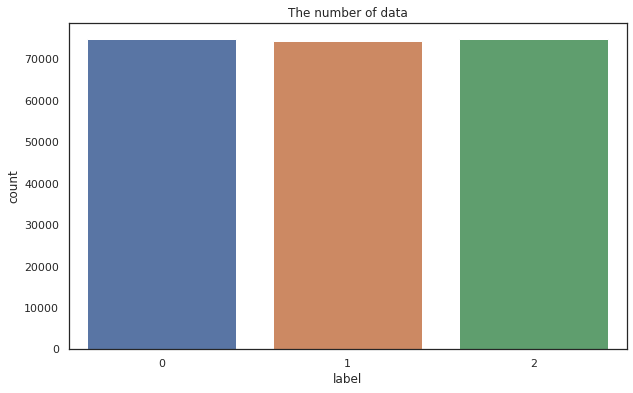

In [29]:
print("The total number of data: ", len(train_df))
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=train_df)
plt.title('The number of data')
plt.show()

# Tokenize

In [24]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK', filter=True):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]
    num_words = len(all_words)
    print('The number of all words: ', num_words)

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)
    print('The number of uniqu words: ', len(bow))
    
    if filter:
        freqs = {}
        for key in counts:
            freqs[key] = counts[key]/num_words

        # Lower bound rate. Less frequent word than this rate will be dropped
        # 1 million data -> appears at least 10 of them = 0.000001
        low_cutoff = 0.000001

        # Top X frequent words that will be dropped
        high_cutoff = 20

        # The k most common words in the corpus. Use `high_cutoff` as the k.
        K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])
        print("Most common words to be removed: ", zip(K_most_common, K_most_common_values))

        filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
        print('The number of filtered words: : ', len(filtered_words))
        
        # A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
        vocab = {word: ii for ii, word in enumerate(filtered_words, 1)}
        # Reverse of the `vocab` dictionary. The key is word id and value is the word. 
        id2vocab = {v: k for k, v in vocab.items()}
        # tokenized with the words not in `filtered_words` removed.
        # Memo: Don't use filtered_word but use vocab instead as looking up a dictionary is much faster
        print('Total Messages (before filtering): ', len(tokenized))
        tokenized = [[word for word in message if word in vocab] for message in tokenized]
        print('Total Messages (after filtering): ', len(tokenized))
        tokenized_text = [" ".join(words) for words in tokenized]
        all_words = [word for text in tokenized for word in text]
        counts = Counter(all_words)
        bow = sorted(counts, key=counts.get, reverse=True)
    else:        
        # Indexing vocabrary, starting from 1.
        vocab = {word: ii for ii, word in enumerate(counts, 1)}
        id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    tmp_dict = {
        "tokenized": tokenized,
        "tokenized_text": tokenized_text,
        "token_ids": token_ids,
        "label": list(df['label'])
    }

    new_df = pd.DataFrame(tmp_dict)

    return new_df, bow, vocab, id2vocab


# Modeling and Training
## Common Functions

In [25]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [26]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [27]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


In [19]:
result_dict = {
    "Model": ['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: Bert']*2,
    "Metrics": ['Accuracy']*5 + ['F1 Score']*5,
    "Score": [0, 0.77, 0.77, 0.78, 0.91] + [0, 0.76, 0.77, 0.77, 0.91]
}
result_metrics = pd.DataFrame(result_dict)

# A. Lexicon
This was not possible as almost all tweets do not include words in the lexicon. Need to make a specific dictionary for tweets to perform this approach. so skip this time.

# B. Tfidf
### Train and Test Data

(224257, 3)



The number of all words:  2110810
The number of uniqu words:  37031
Most common words to be removed:  <zip object at 0x7f039a419248>
The number of filtered words: :  14323
Total Messages (before filtering):  224257
Total Messages (after filtering):  224257
(224257, 4)


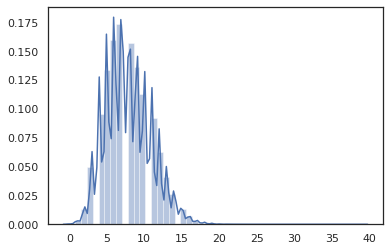

In [30]:
# Tokenize
print(train_df.shape)
new_train_df, bow, vocab, id2vocab = tokenize_df(train_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK', filter=True)
print(new_train_df.shape)
sns.distplot([len(x) for x in new_train_df['tokenized']])

(63196, 4)


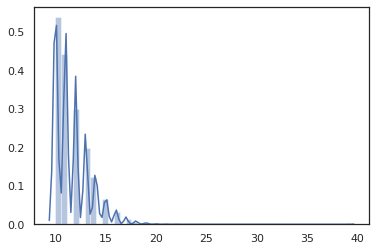

In [32]:
new_train_df = new_train_df.loc[new_train_df['tokenized'].apply(lambda x: len(x)) >= 10]
new_train_df.reset_index(drop=True, inplace=True)
print(new_train_df.shape)
sns.distplot([len(x) for x in new_train_df['tokenized']])


In [33]:
# Don't use more than 100,000 data
if new_train_df.shape[0] > 100000:
    new_train_df = new_train_df[:100000]

In [34]:
# X and Y data used
Y_data = new_train_df['label']
X_data = new_train_df['tokenized_text']

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

In [35]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[2020-07-15 07:56:46,365][INFO] ## Training - acc: 0.81446317, f1: 0.81163604
[2020-07-15 07:56:46,374][INFO] ## Test - acc: 0.75482595, f1: 0.75073931


In [36]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-15 07:58:21,405][INFO] ## Training - acc: 0.99782419, f1: 0.99771504
[2020-07-15 07:58:21,413][INFO] ## Test - acc: 0.76685127, f1: 0.76231102


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 7 folds for each of 20 candidates, totalling 140 fits


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 67.1min finished


Best Score:  0.7593518852441805
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__n_estimators': 200}


[2020-07-15 09:07:47,013][INFO] ## Training - acc: 0.99675607, f1: 0.99662625
[2020-07-15 09:07:47,022][INFO] ## Test - acc: 0.76906646, f1: 0.76437653


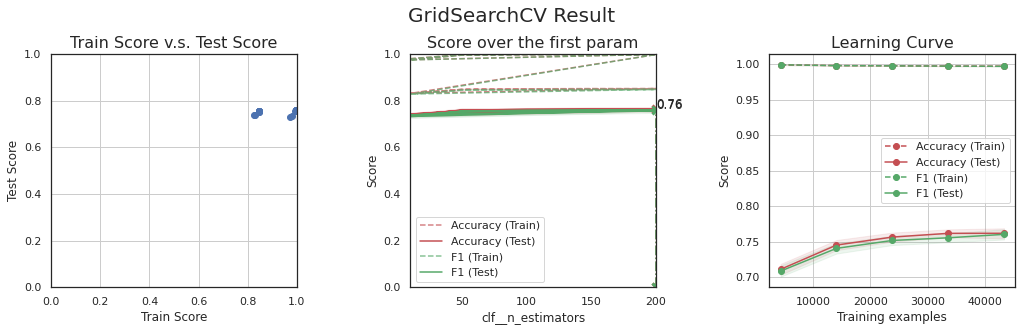

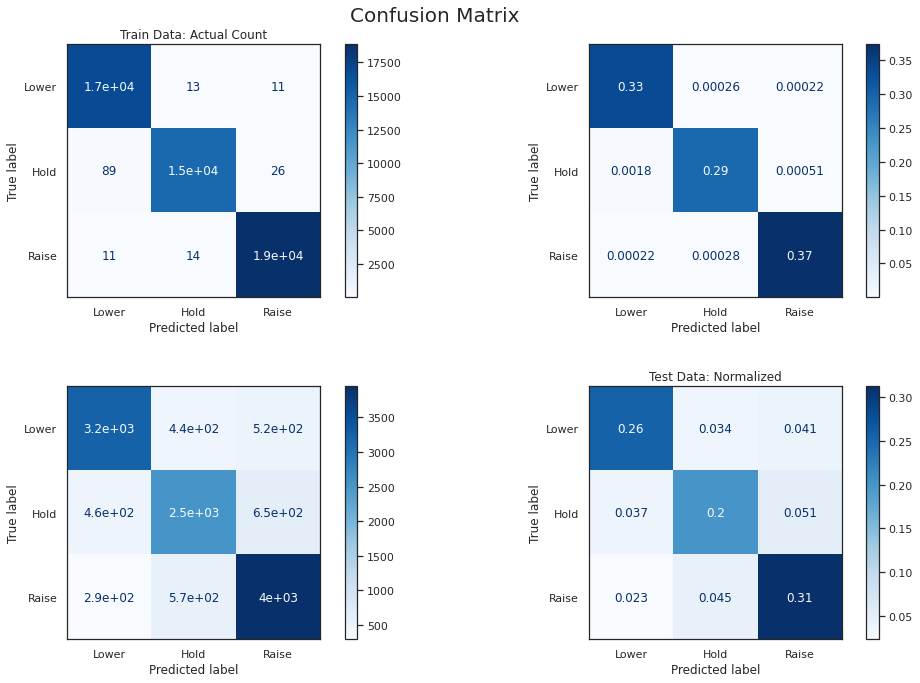

In [37]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

# C. LSTM (RNN)

### Input Data


The number of all words:  3665392
The number of uniqu words:  45941
Most common words to be removed:  <zip object at 0x7f03917a2048>
The number of filtered words: :  15892
Total Messages (before filtering):  224257
Total Messages (after filtering):  224257
(224257, 4)


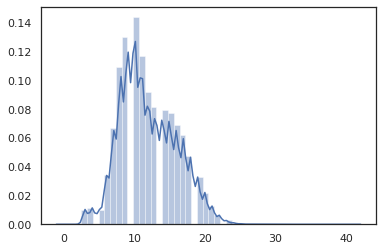

In [38]:
# Tokenize
new_train_df, bow, vocab, id2vocab = tokenize_df(train_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own', filter=True)
sns.distplot([len(x) for x in new_train_df['tokenized']])
print(new_train_df.shape)

In [39]:
new_train_df.groupby(by=['label'])['label'].count()

label
0    74832
1    74446
2    74979
Name: label, dtype: int64

(155817, 4)


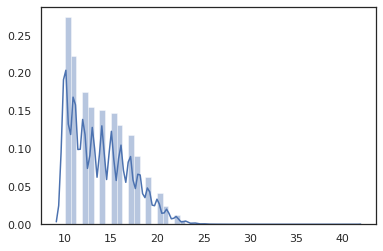

In [40]:
new_train_df = new_train_df.loc[new_train_df['tokenized'].apply(lambda x: len(x)) >= 10]
new_train_df.reset_index(drop=True, inplace=True)
print(new_train_df.shape)
sns.distplot([len(x) for x in new_train_df['tokenized']])

In [41]:
# Don't use more than 100,000 data
if new_train_df.shape[0] > 100000:
    new_train_df = new_train_df[:100000]

In [42]:
new_train_df.head()

,tokenized,tokenized_text,token_ids,label
0,"[drop, per, week, after, spike, if, no, news, ...",drop per week after spike if no news months ba...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 11, 12, 13,...",0
1,"[catalysts, continuing, new, uptrend, pill, pa...",catalysts continuing new uptrend pill pack buy...,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",2
2,"[staanalystalert, mkm, partners, set, price, t...",staanalystalert mkm partners set price target ...,"[34, 35, 36, 37, 38, 39, 40, 41, 25, 42, 39, 3...",2
3,"[breakouts, base, gap, day, ma, gap, gap, gap,...",breakouts base gap day ma gap gap gap day ma,"[47, 48, 49, 29, 50, 49, 49, 49, 29, 50]",2
4,"[during, youtube, interview, mitch, couldn, t,...",during youtube interview mitch couldn t rememb...,"[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 7...",1


In [43]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = new_train_df['label']
X_data = new_train_df['token_ids'] 

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Model
#### Embed -> RNN -> Dense -> Softmax

In [44]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [45]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [46]:
def dataloader(messages, labels, sequence_length=20, batch_size=64, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [47]:
# Test
text_batch, labels = next(iter(dataloader(X_train, y_train)))
model = TextClassifier(len(vocab), 512, 128, 64, 3)
hidden = model.init_hidden(64)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


tensor([[-1.0943, -1.1265, -1.0758],
        [-1.1060, -1.1891, -1.0089],
        [-1.0477, -1.3268, -0.9573],
        [-1.1421, -1.0886, -1.0666],
        [-1.0383, -1.0441, -1.2243],
        [-1.0894, -1.1145, -1.0922],
        [-1.2352, -0.9958, -1.0794],
        [-1.0521, -1.2703, -0.9941],
        [-1.0067, -1.1439, -1.1520],
        [-0.9498, -1.1281, -1.2394],
        [-1.1106, -1.1575, -1.0318],
        [-1.0109, -1.2246, -1.0722],
        [-1.0561, -1.0657, -1.1786],
        [-1.1270, -1.1673, -1.0084],
        [-1.1264, -1.1619, -1.0136],
        [-1.0911, -1.0780, -1.1274],
        [-1.1207, -1.1022, -1.0735],
        [-1.0592, -1.0743, -1.1656],
        [-1.0709, -1.1436, -1.0828],
        [-1.0660, -1.1156, -1.1151],
        [-1.0553, -1.1480, -1.0947],
        [-1.0639, -1.1688, -1.0666],
        [-1.1101, -1.1174, -1.0690],
        [-1.1426, -1.0710, -1.0837],
        [-1.2305, -1.0481, -1.0293],
        [-1.0888, -1.1351, -1.0730],
        [-1.0918, -1.1039, -1.1001],
 

### Configure the model and train!

In [48]:
# Set model
!export CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab), 512, 128, 32, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(15892, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

In [49]:
def train_model(model, epochs=7, batch_size=64, learning_rate=1e-4, sequence_length=64, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, labels in dataloader(
                        X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Strongly Negative', 'Negative', 'Neutral', 'Positive', 'Strongly Positive']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/15... Step: 10... Loss: 1.575845... Val Loss: 1.589456 Accuracy: 0.320162 F1 Score: 0.125876
Epoch: 1/15... Step: 20... Loss: 1.582289... Val Loss: 1.573279 Accuracy: 0.340144 F1 Score: 0.126958
Epoch: 1/15... Step: 30... Loss: 1.555030... Val Loss: 1.554830 Accuracy: 0.340294 F1 Score: 0.169264
Epoch: 1/15... Step: 40... Loss: 1.514013... Val Loss: 1.531633 Accuracy: 0.340294 F1 Score: 0.169264
Epoch: 1/15... Step: 50... Loss: 1.500412... Val Loss: 1.498394 Accuracy: 0.340294 F1 Score: 0.169264
Epoch: 1/15... Step: 60... Loss: 1.418943... Val Loss: 1.439811 Accuracy: 0.340294 F1 Score: 0.169264
Epoch: 1/15... Step: 70... Loss: 1.362852... Val Loss: 1.293827 Accuracy: 0.392077 F1 Score: 0.277249
Epoch: 1/15... Step: 80... Loss: 1.118411... Val Loss: 1.132234 Accuracy: 0.429487 F1 Score: 0.200299
Epoch: 1/15... Step: 90... Loss: 1.152361... Val Loss: 1.096318 Accuracy: 0.429487 F1 Score: 0.200299
Epoch: 1/15... Step: 100... Loss: 1.064264... Val Loss: 1.083915 

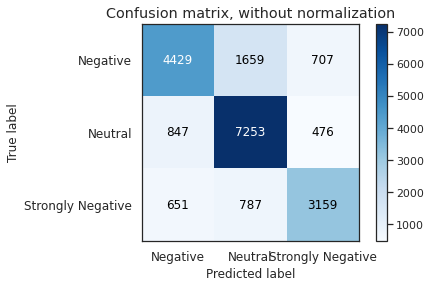

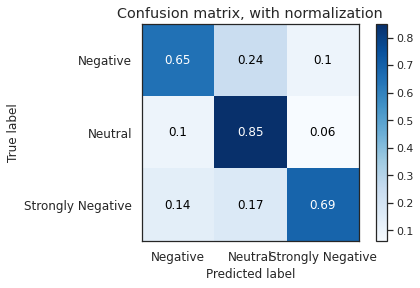

Starting epoch 2
Epoch: 2/15... Step: 10... Loss: 0.495059... Val Loss: 0.615529 Accuracy: 0.743089 F1 Score: 0.736254
Epoch: 2/15... Step: 20... Loss: 0.702238... Val Loss: 0.613645 Accuracy: 0.740335 F1 Score: 0.728079
Epoch: 2/15... Step: 30... Loss: 0.631565... Val Loss: 0.618356 Accuracy: 0.743189 F1 Score: 0.736321
Epoch: 2/15... Step: 40... Loss: 0.500912... Val Loss: 0.607706 Accuracy: 0.746795 F1 Score: 0.735850
Epoch: 2/15... Step: 50... Loss: 0.714433... Val Loss: 0.606029 Accuracy: 0.746595 F1 Score: 0.736051
Epoch: 2/15... Step: 60... Loss: 0.668804... Val Loss: 0.607189 Accuracy: 0.747496 F1 Score: 0.739402
Epoch: 2/15... Step: 70... Loss: 0.824397... Val Loss: 0.603974 Accuracy: 0.750000 F1 Score: 0.739745
Epoch: 2/15... Step: 80... Loss: 0.738250... Val Loss: 0.613055 Accuracy: 0.747746 F1 Score: 0.739449
Epoch: 2/15... Step: 90... Loss: 0.651275... Val Loss: 0.606067 Accuracy: 0.746244 F1 Score: 0.734121
Epoch: 2/15... Step: 100... Loss: 0.711601... Val Loss: 0.608017 

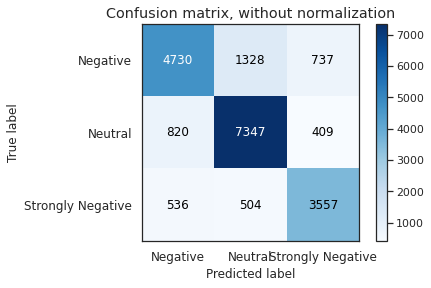

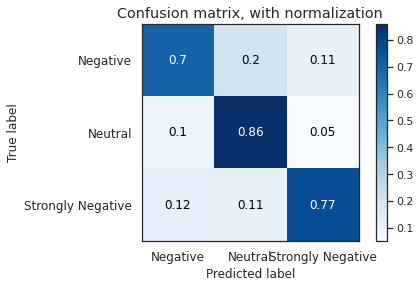

Starting epoch 3
Epoch: 3/15... Step: 10... Loss: 0.424033... Val Loss: 0.537078 Accuracy: 0.781951 F1 Score: 0.775910
Epoch: 3/15... Step: 20... Loss: 0.565226... Val Loss: 0.530945 Accuracy: 0.784054 F1 Score: 0.777178
Epoch: 3/15... Step: 30... Loss: 0.560088... Val Loss: 0.534492 Accuracy: 0.783203 F1 Score: 0.775776
Epoch: 3/15... Step: 40... Loss: 0.415116... Val Loss: 0.529757 Accuracy: 0.785907 F1 Score: 0.780168
Epoch: 3/15... Step: 50... Loss: 0.636563... Val Loss: 0.534488 Accuracy: 0.782101 F1 Score: 0.774058
Epoch: 3/15... Step: 60... Loss: 0.540841... Val Loss: 0.532128 Accuracy: 0.784956 F1 Score: 0.779982
Epoch: 3/15... Step: 70... Loss: 0.732292... Val Loss: 0.530339 Accuracy: 0.783604 F1 Score: 0.775943
Epoch: 3/15... Step: 80... Loss: 0.635494... Val Loss: 0.536478 Accuracy: 0.782452 F1 Score: 0.775190
Epoch: 3/15... Step: 90... Loss: 0.556084... Val Loss: 0.529817 Accuracy: 0.783854 F1 Score: 0.775878
Epoch: 3/15... Step: 100... Loss: 0.593595... Val Loss: 0.535144 

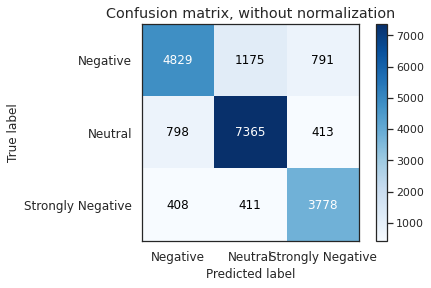

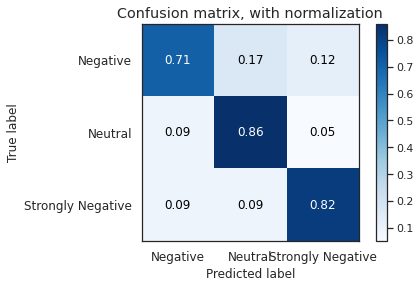

Starting epoch 4
Epoch: 4/15... Step: 10... Loss: 0.308622... Val Loss: 0.500880 Accuracy: 0.799279 F1 Score: 0.794168
Epoch: 4/15... Step: 20... Loss: 0.510976... Val Loss: 0.498050 Accuracy: 0.801082 F1 Score: 0.795649
Epoch: 4/15... Step: 30... Loss: 0.504241... Val Loss: 0.501485 Accuracy: 0.796875 F1 Score: 0.790275
Epoch: 4/15... Step: 40... Loss: 0.339679... Val Loss: 0.494078 Accuracy: 0.802835 F1 Score: 0.798017
Epoch: 4/15... Step: 50... Loss: 0.581813... Val Loss: 0.502501 Accuracy: 0.796625 F1 Score: 0.790258
Epoch: 4/15... Step: 60... Loss: 0.428036... Val Loss: 0.499543 Accuracy: 0.800681 F1 Score: 0.796964
Epoch: 4/15... Step: 70... Loss: 0.672964... Val Loss: 0.496319 Accuracy: 0.798678 F1 Score: 0.792697
Epoch: 4/15... Step: 80... Loss: 0.595484... Val Loss: 0.495885 Accuracy: 0.799279 F1 Score: 0.793423
Epoch: 4/15... Step: 90... Loss: 0.490966... Val Loss: 0.494375 Accuracy: 0.799429 F1 Score: 0.793604
Epoch: 4/15... Step: 100... Loss: 0.529159... Val Loss: 0.499227 

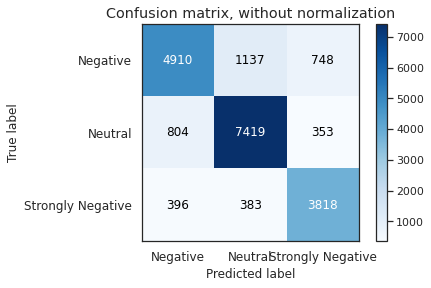

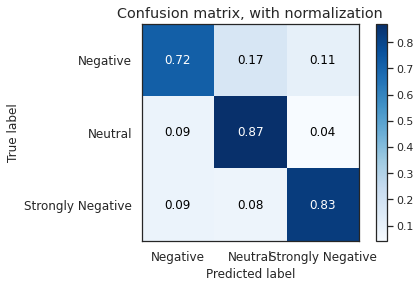

Starting epoch 5
Epoch: 5/15... Step: 10... Loss: 0.282984... Val Loss: 0.483529 Accuracy: 0.808744 F1 Score: 0.804235
Epoch: 5/15... Step: 20... Loss: 0.457689... Val Loss: 0.481099 Accuracy: 0.809645 F1 Score: 0.804655
Epoch: 5/15... Step: 30... Loss: 0.450100... Val Loss: 0.481963 Accuracy: 0.807141 F1 Score: 0.801555
Epoch: 5/15... Step: 40... Loss: 0.327894... Val Loss: 0.478257 Accuracy: 0.810647 F1 Score: 0.806523
Epoch: 5/15... Step: 50... Loss: 0.510802... Val Loss: 0.482906 Accuracy: 0.806440 F1 Score: 0.801012
Epoch: 5/15... Step: 60... Loss: 0.355980... Val Loss: 0.482689 Accuracy: 0.809545 F1 Score: 0.806276
Epoch: 5/15... Step: 70... Loss: 0.610294... Val Loss: 0.480318 Accuracy: 0.805940 F1 Score: 0.800754
Epoch: 5/15... Step: 80... Loss: 0.561039... Val Loss: 0.476735 Accuracy: 0.808293 F1 Score: 0.802836
Epoch: 5/15... Step: 90... Loss: 0.484019... Val Loss: 0.475395 Accuracy: 0.808894 F1 Score: 0.804443
Epoch: 5/15... Step: 100... Loss: 0.451061... Val Loss: 0.478710 

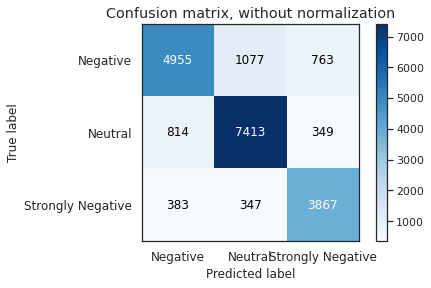

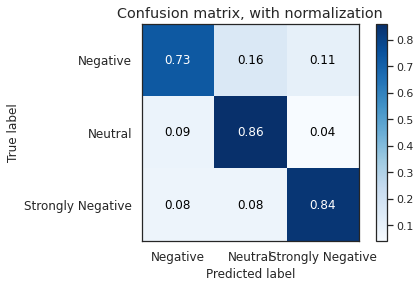

Starting epoch 6
Epoch: 6/15... Step: 10... Loss: 0.260517... Val Loss: 0.482416 Accuracy: 0.812250 F1 Score: 0.807173
Epoch: 6/15... Step: 20... Loss: 0.436883... Val Loss: 0.477938 Accuracy: 0.812901 F1 Score: 0.807748
Epoch: 6/15... Step: 30... Loss: 0.454829... Val Loss: 0.473157 Accuracy: 0.812200 F1 Score: 0.806668
Epoch: 6/15... Step: 40... Loss: 0.293247... Val Loss: 0.469803 Accuracy: 0.814203 F1 Score: 0.810557
Epoch: 6/15... Step: 50... Loss: 0.507552... Val Loss: 0.478445 Accuracy: 0.810447 F1 Score: 0.805456
Epoch: 6/15... Step: 60... Loss: 0.311692... Val Loss: 0.476046 Accuracy: 0.813251 F1 Score: 0.810388
Epoch: 6/15... Step: 70... Loss: 0.584246... Val Loss: 0.471553 Accuracy: 0.812149 F1 Score: 0.807492
Epoch: 6/15... Step: 80... Loss: 0.504393... Val Loss: 0.469698 Accuracy: 0.812851 F1 Score: 0.807401
Epoch: 6/15... Step: 90... Loss: 0.459846... Val Loss: 0.467924 Accuracy: 0.815455 F1 Score: 0.811658
Epoch: 6/15... Step: 100... Loss: 0.400119... Val Loss: 0.470697 

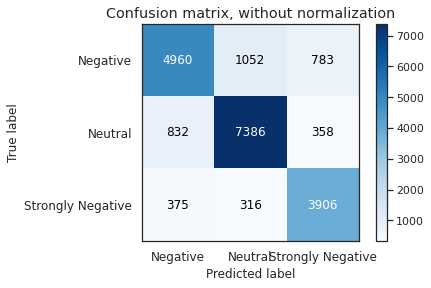

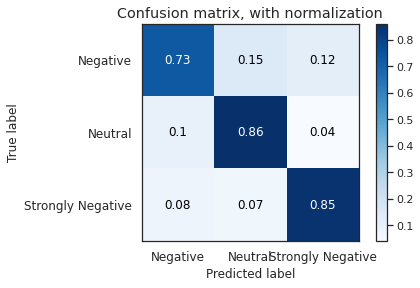

Starting epoch 7
Epoch: 7/15... Step: 10... Loss: 0.264979... Val Loss: 0.482723 Accuracy: 0.815755 F1 Score: 0.811428
Epoch: 7/15... Step: 20... Loss: 0.389036... Val Loss: 0.481294 Accuracy: 0.813452 F1 Score: 0.808640
Epoch: 7/15... Step: 30... Loss: 0.393134... Val Loss: 0.470233 Accuracy: 0.813952 F1 Score: 0.808910
Epoch: 7/15... Step: 40... Loss: 0.243785... Val Loss: 0.467336 Accuracy: 0.816006 F1 Score: 0.812010
Epoch: 7/15... Step: 50... Loss: 0.485844... Val Loss: 0.480187 Accuracy: 0.813401 F1 Score: 0.808848
Epoch: 7/15... Step: 60... Loss: 0.268068... Val Loss: 0.476186 Accuracy: 0.815855 F1 Score: 0.813294
Epoch: 7/15... Step: 70... Loss: 0.506382... Val Loss: 0.469737 Accuracy: 0.815254 F1 Score: 0.810800
Epoch: 7/15... Step: 80... Loss: 0.458374... Val Loss: 0.468480 Accuracy: 0.814904 F1 Score: 0.809668
Epoch: 7/15... Step: 90... Loss: 0.406691... Val Loss: 0.466609 Accuracy: 0.816006 F1 Score: 0.812212
Epoch: 7/15... Step: 100... Loss: 0.384250... Val Loss: 0.471559 

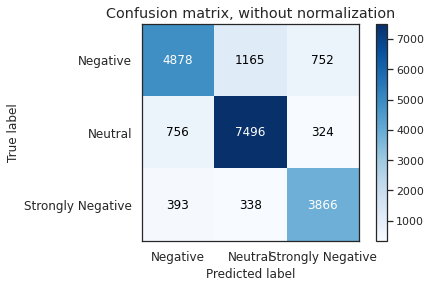

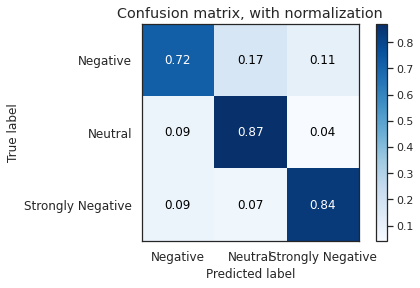

Starting epoch 8
Epoch: 8/15... Step: 10... Loss: 0.186283... Val Loss: 0.489929 Accuracy: 0.816306 F1 Score: 0.812115
Epoch: 8/15... Step: 20... Loss: 0.394816... Val Loss: 0.493966 Accuracy: 0.813752 F1 Score: 0.809095
Epoch: 8/15... Step: 30... Loss: 0.408881... Val Loss: 0.475756 Accuracy: 0.815905 F1 Score: 0.811503
Epoch: 8/15... Step: 40... Loss: 0.203408... Val Loss: 0.473815 Accuracy: 0.816607 F1 Score: 0.813018
Epoch: 8/15... Step: 50... Loss: 0.448846... Val Loss: 0.493867 Accuracy: 0.813301 F1 Score: 0.808264
Epoch: 8/15... Step: 60... Loss: 0.218413... Val Loss: 0.486488 Accuracy: 0.815405 F1 Score: 0.812729
Epoch: 8/15... Step: 70... Loss: 0.470374... Val Loss: 0.482986 Accuracy: 0.813602 F1 Score: 0.808754
Epoch: 8/15... Step: 80... Loss: 0.416287... Val Loss: 0.473973 Accuracy: 0.815304 F1 Score: 0.810416
Epoch: 8/15... Step: 90... Loss: 0.422925... Val Loss: 0.472223 Accuracy: 0.816556 F1 Score: 0.812901
Epoch: 8/15... Step: 100... Loss: 0.330045... Val Loss: 0.479616 

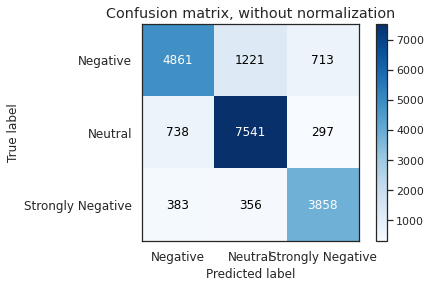

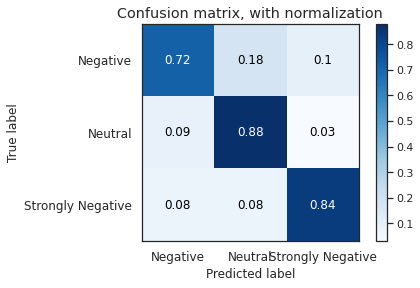

Starting epoch 9
Epoch: 9/15... Step: 10... Loss: 0.194979... Val Loss: 0.501665 Accuracy: 0.817758 F1 Score: 0.814082
Epoch: 9/15... Step: 20... Loss: 0.342394... Val Loss: 0.511611 Accuracy: 0.814704 F1 Score: 0.810096
Epoch: 9/15... Step: 30... Loss: 0.358174... Val Loss: 0.489648 Accuracy: 0.814503 F1 Score: 0.810094
Epoch: 9/15... Step: 40... Loss: 0.204292... Val Loss: 0.489532 Accuracy: 0.817208 F1 Score: 0.813598
Epoch: 9/15... Step: 50... Loss: 0.414537... Val Loss: 0.506096 Accuracy: 0.813702 F1 Score: 0.809042
Epoch: 9/15... Step: 60... Loss: 0.181315... Val Loss: 0.496919 Accuracy: 0.816857 F1 Score: 0.813815
Epoch: 9/15... Step: 70... Loss: 0.419853... Val Loss: 0.497214 Accuracy: 0.813952 F1 Score: 0.809408
Epoch: 9/15... Step: 80... Loss: 0.366695... Val Loss: 0.484696 Accuracy: 0.814403 F1 Score: 0.809074
Epoch: 9/15... Step: 90... Loss: 0.348543... Val Loss: 0.484575 Accuracy: 0.816206 F1 Score: 0.812595
Epoch: 9/15... Step: 100... Loss: 0.309806... Val Loss: 0.496432 

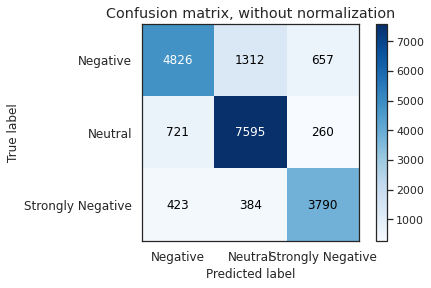

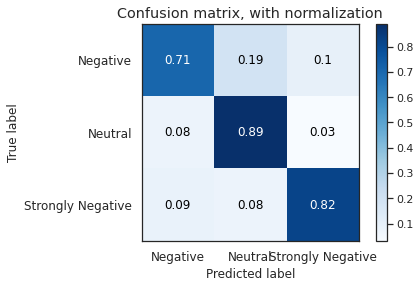

Starting epoch 10
Epoch: 10/15... Step: 10... Loss: 0.183028... Val Loss: 0.520066 Accuracy: 0.816306 F1 Score: 0.813059
Epoch: 10/15... Step: 20... Loss: 0.338387... Val Loss: 0.535190 Accuracy: 0.812550 F1 Score: 0.807649
Epoch: 10/15... Step: 30... Loss: 0.334852... Val Loss: 0.511877 Accuracy: 0.814303 F1 Score: 0.810373
Epoch: 10/15... Step: 40... Loss: 0.149318... Val Loss: 0.502086 Accuracy: 0.813952 F1 Score: 0.809595
Epoch: 10/15... Step: 50... Loss: 0.396077... Val Loss: 0.527198 Accuracy: 0.813552 F1 Score: 0.808701
Epoch: 10/15... Step: 60... Loss: 0.184322... Val Loss: 0.516093 Accuracy: 0.814704 F1 Score: 0.811971
Epoch: 10/15... Step: 70... Loss: 0.362691... Val Loss: 0.504276 Accuracy: 0.813652 F1 Score: 0.808639
Epoch: 10/15... Step: 80... Loss: 0.323160... Val Loss: 0.509025 Accuracy: 0.810547 F1 Score: 0.804388
Epoch: 10/15... Step: 90... Loss: 0.303831... Val Loss: 0.501841 Accuracy: 0.813452 F1 Score: 0.810136
Epoch: 10/15... Step: 100... Loss: 0.281948... Val Loss

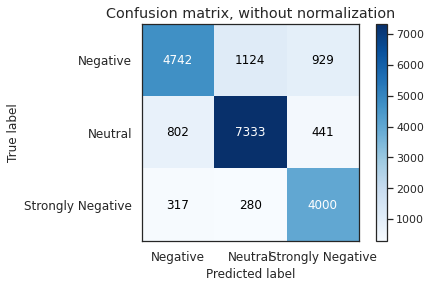

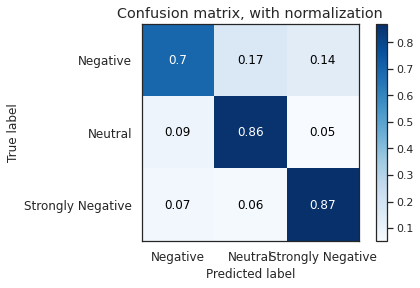

Starting epoch 11
Epoch: 11/15... Step: 10... Loss: 0.158273... Val Loss: 0.565432 Accuracy: 0.810347 F1 Score: 0.805965
Epoch: 11/15... Step: 20... Loss: 0.318705... Val Loss: 0.560438 Accuracy: 0.810897 F1 Score: 0.806639
Epoch: 11/15... Step: 30... Loss: 0.300407... Val Loss: 0.540786 Accuracy: 0.811949 F1 Score: 0.807414
Epoch: 11/15... Step: 40... Loss: 0.201460... Val Loss: 0.538985 Accuracy: 0.811749 F1 Score: 0.807881
Epoch: 11/15... Step: 50... Loss: 0.393545... Val Loss: 0.562220 Accuracy: 0.810497 F1 Score: 0.805432
Epoch: 11/15... Step: 60... Loss: 0.156045... Val Loss: 0.542460 Accuracy: 0.811398 F1 Score: 0.808108
Epoch: 11/15... Step: 70... Loss: 0.333347... Val Loss: 0.533547 Accuracy: 0.812500 F1 Score: 0.808053
Epoch: 11/15... Step: 80... Loss: 0.339450... Val Loss: 0.529982 Accuracy: 0.808944 F1 Score: 0.803215
Epoch: 11/15... Step: 90... Loss: 0.267443... Val Loss: 0.526080 Accuracy: 0.813151 F1 Score: 0.809667
Epoch: 11/15... Step: 100... Loss: 0.267395... Val Loss

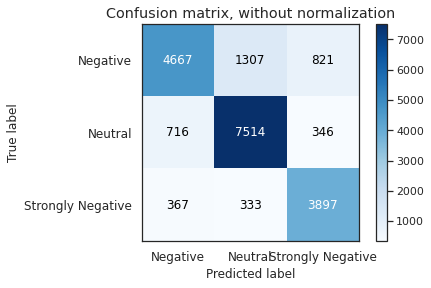

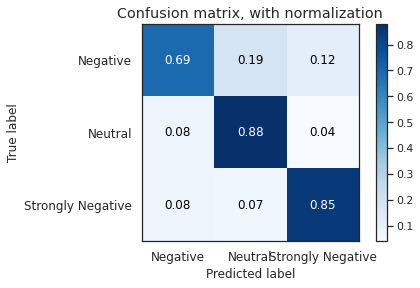

Starting epoch 12
Epoch: 12/15... Step: 10... Loss: 0.133323... Val Loss: 0.600509 Accuracy: 0.809295 F1 Score: 0.804749
Epoch: 12/15... Step: 20... Loss: 0.295612... Val Loss: 0.608935 Accuracy: 0.808894 F1 Score: 0.804808
Epoch: 12/15... Step: 30... Loss: 0.255552... Val Loss: 0.582547 Accuracy: 0.809195 F1 Score: 0.804649
Epoch: 12/15... Step: 40... Loss: 0.127029... Val Loss: 0.571266 Accuracy: 0.809896 F1 Score: 0.805520
Epoch: 12/15... Step: 50... Loss: 0.303007... Val Loss: 0.594160 Accuracy: 0.809295 F1 Score: 0.804798
Epoch: 12/15... Step: 60... Loss: 0.151564... Val Loss: 0.605115 Accuracy: 0.809044 F1 Score: 0.805823
Epoch: 12/15... Step: 70... Loss: 0.285511... Val Loss: 0.583391 Accuracy: 0.809445 F1 Score: 0.804425
Epoch: 12/15... Step: 80... Loss: 0.310409... Val Loss: 0.567275 Accuracy: 0.806490 F1 Score: 0.800424
Epoch: 12/15... Step: 90... Loss: 0.233987... Val Loss: 0.562875 Accuracy: 0.807792 F1 Score: 0.804478
Epoch: 12/15... Step: 100... Loss: 0.202071... Val Loss

KeyboardInterrupt: ignored

In [50]:
train_model(model)

# D. Glove Word Embedding + LSTM
Use GloVe word embedding

### Download GloVe files

In [50]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [51]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [52]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

14679 words found out of 15892 words in vocab.
(15893, 300)


In [53]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(lstm_size, dense_size)
        # self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        # dense_out = self.fc1(lstm_out)
        # out = self.fc2(dense_out)
        out = self.fc(lstm_out)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [54]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(15893, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/7... Step: 10... Loss: 1.109360... Val Loss: 1.102202 Accuracy: 0.344601 F1 Score: 0.279327
Epoch: 1/7... Step: 20... Loss: 1.102423... Val Loss: 1.099110 Accuracy: 0.360176 F1 Score: 0.291888
Epoch: 1/7... Step: 30... Loss: 1.089336... Val Loss: 1.096513 Accuracy: 0.358874 F1 Score: 0.283793
Epoch: 1/7... Step: 40... Loss: 1.098724... Val Loss: 1.094082 Accuracy: 0.394030 F1 Score: 0.339948
Epoch: 1/7... Step: 50... Loss: 1.082157... Val Loss: 1.091611 Accuracy: 0.427183 F1 Score: 0.368071
Epoch: 1/7... Step: 60... Loss: 1.096787... Val Loss: 1.089788 Accuracy: 0.426783 F1 Score: 0.342817
Epoch: 1/7... Step: 70... Loss: 1.078070... Val Loss: 1.087865 Accuracy: 0.428035 F1 Score: 0.335531
Epoch: 1/7... Step: 80... Loss: 1.087175... Val Loss: 1.085616 Accuracy: 0.433143 F1 Score: 0.336594
Epoch: 1/7... Step: 90... Loss: 1.094194... Val Loss: 1.083138 Accuracy: 0.433093 F1 Score: 0.338707
Epoch: 1/7... Step: 100... Loss: 1.089685... Val Loss: 1.079159 Accuracy: 

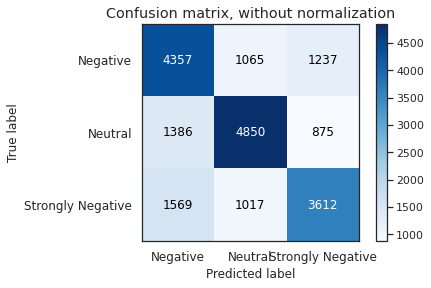

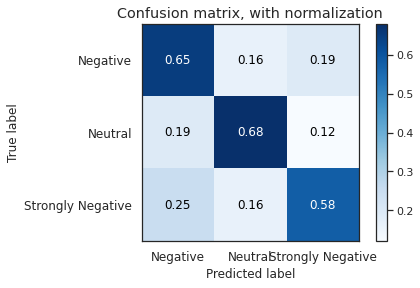

Starting epoch 2
Epoch: 2/7... Step: 10... Loss: 0.851357... Val Loss: 0.784262 Accuracy: 0.638472 F1 Score: 0.630773
Epoch: 2/7... Step: 20... Loss: 0.839272... Val Loss: 0.786344 Accuracy: 0.638822 F1 Score: 0.637476
Epoch: 2/7... Step: 30... Loss: 0.762604... Val Loss: 0.775404 Accuracy: 0.644181 F1 Score: 0.638832
Epoch: 2/7... Step: 40... Loss: 0.796135... Val Loss: 0.774490 Accuracy: 0.646134 F1 Score: 0.643414
Epoch: 2/7... Step: 50... Loss: 0.855353... Val Loss: 0.770405 Accuracy: 0.648588 F1 Score: 0.645529
Epoch: 2/7... Step: 60... Loss: 0.902506... Val Loss: 0.777795 Accuracy: 0.644732 F1 Score: 0.644206
Epoch: 2/7... Step: 70... Loss: 0.747247... Val Loss: 0.769462 Accuracy: 0.649239 F1 Score: 0.645450
Epoch: 2/7... Step: 80... Loss: 0.883190... Val Loss: 0.767767 Accuracy: 0.650591 F1 Score: 0.647537
Epoch: 2/7... Step: 90... Loss: 0.916660... Val Loss: 0.770561 Accuracy: 0.646234 F1 Score: 0.643243
Epoch: 2/7... Step: 100... Loss: 0.795180... Val Loss: 0.771052 Accuracy: 

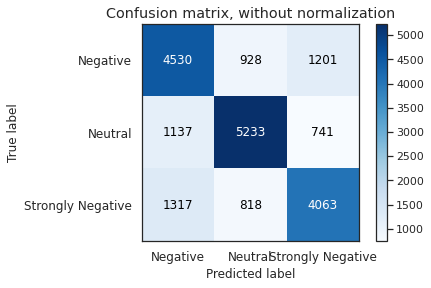

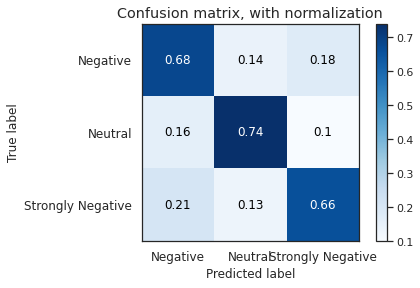

Starting epoch 3
Epoch: 3/7... Step: 10... Loss: 0.748853... Val Loss: 0.710078 Accuracy: 0.686548 F1 Score: 0.680335
Epoch: 3/7... Step: 20... Loss: 0.788407... Val Loss: 0.707680 Accuracy: 0.686899 F1 Score: 0.685373
Epoch: 3/7... Step: 30... Loss: 0.682704... Val Loss: 0.701159 Accuracy: 0.692057 F1 Score: 0.687396
Epoch: 3/7... Step: 40... Loss: 0.663588... Val Loss: 0.699517 Accuracy: 0.692408 F1 Score: 0.691275
Epoch: 3/7... Step: 50... Loss: 0.801451... Val Loss: 0.697050 Accuracy: 0.693860 F1 Score: 0.690711
Epoch: 3/7... Step: 60... Loss: 0.817526... Val Loss: 0.717699 Accuracy: 0.682742 F1 Score: 0.683467
Epoch: 3/7... Step: 70... Loss: 0.653074... Val Loss: 0.697639 Accuracy: 0.695212 F1 Score: 0.690872
Epoch: 3/7... Step: 80... Loss: 0.716446... Val Loss: 0.692943 Accuracy: 0.696464 F1 Score: 0.694234
Epoch: 3/7... Step: 90... Loss: 0.839607... Val Loss: 0.698420 Accuracy: 0.694261 F1 Score: 0.692754
Epoch: 3/7... Step: 100... Loss: 0.647545... Val Loss: 0.693769 Accuracy: 

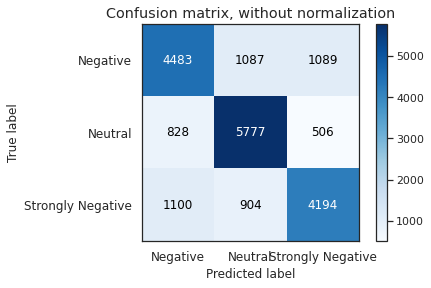

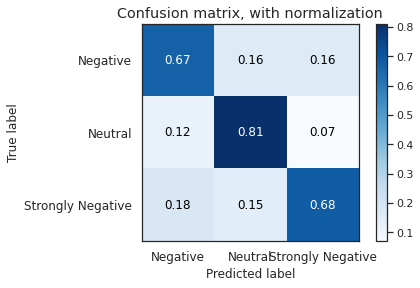

Starting epoch 4
Epoch: 4/7... Step: 10... Loss: 0.645251... Val Loss: 0.651092 Accuracy: 0.721404 F1 Score: 0.718606
Epoch: 4/7... Step: 20... Loss: 0.729165... Val Loss: 0.651435 Accuracy: 0.719902 F1 Score: 0.717951
Epoch: 4/7... Step: 30... Loss: 0.614934... Val Loss: 0.647420 Accuracy: 0.723908 F1 Score: 0.720273
Epoch: 4/7... Step: 40... Loss: 0.554966... Val Loss: 0.645630 Accuracy: 0.725260 F1 Score: 0.723788
Epoch: 4/7... Step: 50... Loss: 0.731964... Val Loss: 0.644238 Accuracy: 0.723458 F1 Score: 0.722037
Epoch: 4/7... Step: 60... Loss: 0.752563... Val Loss: 0.650453 Accuracy: 0.723407 F1 Score: 0.721978
Epoch: 4/7... Step: 70... Loss: 0.605876... Val Loss: 0.650773 Accuracy: 0.721304 F1 Score: 0.720660
Epoch: 4/7... Step: 80... Loss: 0.605232... Val Loss: 0.641697 Accuracy: 0.725411 F1 Score: 0.722376
Epoch: 4/7... Step: 90... Loss: 0.748531... Val Loss: 0.653151 Accuracy: 0.721254 F1 Score: 0.721268
Epoch: 4/7... Step: 100... Loss: 0.598241... Val Loss: 0.643643 Accuracy: 

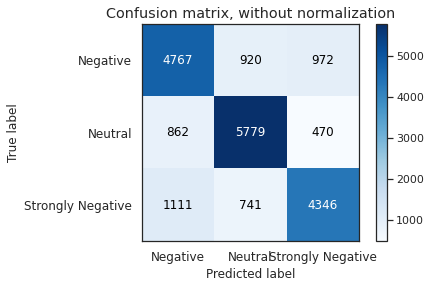

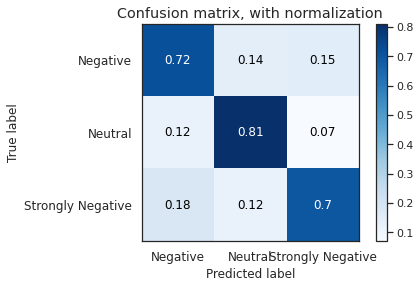

Starting epoch 5
Epoch: 5/7... Step: 10... Loss: 0.610619... Val Loss: 0.621979 Accuracy: 0.740986 F1 Score: 0.738634
Epoch: 5/7... Step: 20... Loss: 0.636151... Val Loss: 0.611942 Accuracy: 0.743189 F1 Score: 0.740465
Epoch: 5/7... Step: 30... Loss: 0.618340... Val Loss: 0.609811 Accuracy: 0.744641 F1 Score: 0.742916
Epoch: 5/7... Step: 40... Loss: 0.507576... Val Loss: 0.610247 Accuracy: 0.746044 F1 Score: 0.744216
Epoch: 5/7... Step: 50... Loss: 0.728590... Val Loss: 0.610100 Accuracy: 0.743540 F1 Score: 0.742470
Epoch: 5/7... Step: 60... Loss: 0.712557... Val Loss: 0.619052 Accuracy: 0.741236 F1 Score: 0.739734
Epoch: 5/7... Step: 70... Loss: 0.533918... Val Loss: 0.613657 Accuracy: 0.741386 F1 Score: 0.740191
Epoch: 5/7... Step: 80... Loss: 0.530649... Val Loss: 0.605460 Accuracy: 0.748798 F1 Score: 0.746480
Epoch: 5/7... Step: 90... Loss: 0.741519... Val Loss: 0.624901 Accuracy: 0.737981 F1 Score: 0.738756
Epoch: 5/7... Step: 100... Loss: 0.537767... Val Loss: 0.610833 Accuracy: 

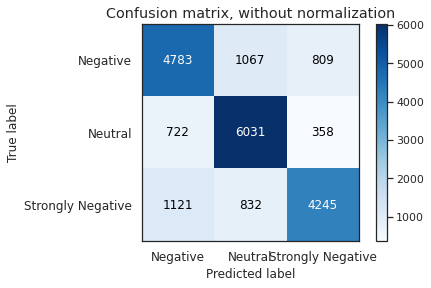

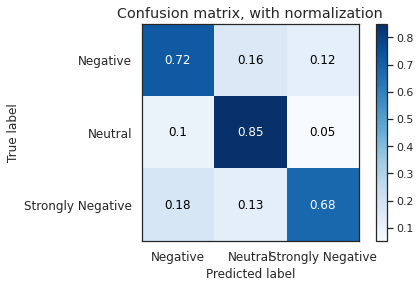

Starting epoch 6
Epoch: 6/7... Step: 10... Loss: 0.576503... Val Loss: 0.596388 Accuracy: 0.754056 F1 Score: 0.752201
Epoch: 6/7... Step: 20... Loss: 0.583557... Val Loss: 0.592701 Accuracy: 0.753305 F1 Score: 0.751679
Epoch: 6/7... Step: 30... Loss: 0.547953... Val Loss: 0.587505 Accuracy: 0.756310 F1 Score: 0.753531
Epoch: 6/7... Step: 40... Loss: 0.441933... Val Loss: 0.586545 Accuracy: 0.756160 F1 Score: 0.755405
Epoch: 6/7... Step: 50... Loss: 0.651569... Val Loss: 0.582273 Accuracy: 0.760066 F1 Score: 0.758295
Epoch: 6/7... Step: 60... Loss: 0.700267... Val Loss: 0.591730 Accuracy: 0.755058 F1 Score: 0.753967
Epoch: 6/7... Step: 70... Loss: 0.509152... Val Loss: 0.585935 Accuracy: 0.757262 F1 Score: 0.755825
Epoch: 6/7... Step: 80... Loss: 0.507492... Val Loss: 0.581681 Accuracy: 0.760317 F1 Score: 0.757962
Epoch: 6/7... Step: 90... Loss: 0.660336... Val Loss: 0.593532 Accuracy: 0.754657 F1 Score: 0.754051
Epoch: 6/7... Step: 100... Loss: 0.522782... Val Loss: 0.584621 Accuracy: 

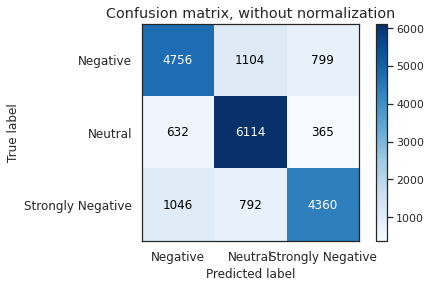

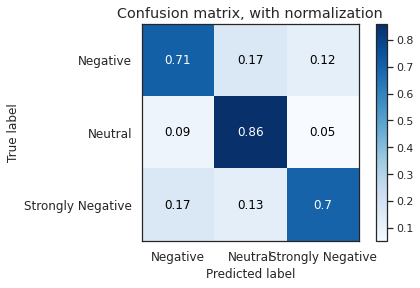

Starting epoch 7
Epoch: 7/7... Step: 10... Loss: 0.545823... Val Loss: 0.577103 Accuracy: 0.764824 F1 Score: 0.764092
Epoch: 7/7... Step: 20... Loss: 0.538582... Val Loss: 0.569255 Accuracy: 0.766827 F1 Score: 0.764439
Epoch: 7/7... Step: 30... Loss: 0.515286... Val Loss: 0.566949 Accuracy: 0.767077 F1 Score: 0.765164
Epoch: 7/7... Step: 40... Loss: 0.422139... Val Loss: 0.569979 Accuracy: 0.766426 F1 Score: 0.765336
Epoch: 7/7... Step: 50... Loss: 0.623504... Val Loss: 0.566367 Accuracy: 0.766977 F1 Score: 0.765798
Epoch: 7/7... Step: 60... Loss: 0.639433... Val Loss: 0.577151 Accuracy: 0.763421 F1 Score: 0.762970
Epoch: 7/7... Step: 70... Loss: 0.434883... Val Loss: 0.575070 Accuracy: 0.762570 F1 Score: 0.761696
Epoch: 7/7... Step: 80... Loss: 0.509476... Val Loss: 0.567823 Accuracy: 0.769431 F1 Score: 0.767211
Epoch: 7/7... Step: 90... Loss: 0.630373... Val Loss: 0.574177 Accuracy: 0.765224 F1 Score: 0.765101
Epoch: 7/7... Step: 100... Loss: 0.477509... Val Loss: 0.565204 Accuracy: 

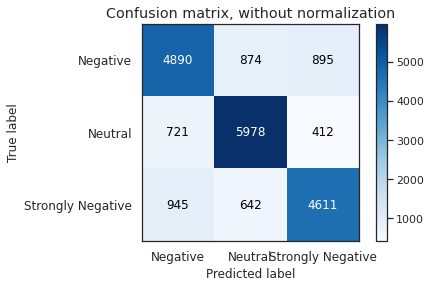

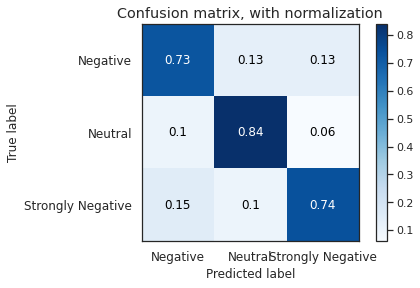

In [55]:
train_model(model)

# E. BERT Model

### Define functions

In [57]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_Bert, get_linear_schedule_with_warmup

In [62]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [63]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [61]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=48):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

### Input Data

In [62]:
print(train_df.shape)

(299992, 3)


In [65]:
train_df['count'] = train_df['sentence'].apply(lambda x: len(tokenizer.tokenize(x)))
bert_train_df = train_df.loc[train_df['count'] >= 15]
bert_train_df.reset_index(drop=True, inplace=True)
print(bert_train_df.shape)

(199670, 4)


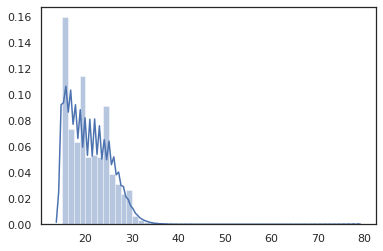

In [66]:
# Check the distribution to decide the maximum length
sns.distplot([len(tokenizer.tokenize(x)) for x in bert_train_df['sentence']])

In [67]:
# Prepare training data
train_set = []
max_seq_length = 32

for index, row in tqdm(bert_train_df.iterrows(), total=bert_train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

train_labels = bert_train_df['label'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

### Define Bert Model

In [68]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [69]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple


tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
   

In [70]:
# Test Tokenizer - Own Implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
outputs = bert_model(text_ids, pad_masks, segment_ids)

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])
text_ids (unsqueezed): 
 tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])
1
output

### Train

In [71]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 5
batch_size = 64
patience = 3
warm_up_proportion = 0.1
max_grad_norm = 1.0
file_name = 'model'
bert_hidden_size = 768
bert_dense_size = 128

In [72]:
def train_bert(fold, train_indices, valid_indices):
    
    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    #bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, 3, dropout=0.1)
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    # Set Loss Function
    # If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    # Set Optimizer
    # Adam with parameter groups
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)

    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {}'.format(num_total_opt_steps))
    optimizer = AdamW_Bert(bert_model.parameters(), lr=learning_rate, correct_bias=False) # To reproduce BertAdam specific behavior set correct_bias=False
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)

            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch

            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = bert_model(x_ids, labels=y_truth)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        bert_model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                loss, logits = bert_model(x_ids, labels=y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        bert_model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            loss, logits = bert_model(x_ids, labels=y_truth)
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()

    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in train_valid_labels[valid_indices]]
    predicted_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()

[2020-07-14 19:24:49,150][INFO] ## ================     fold 0        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-14 19:59:11,594][INFO] ## epoch: 1, train loss: 0.38399643, valid loss: 0.29162718, acc: 0.90114, f1: 0.896125, best_f1: 0.89613
, last lr: 0.000089
[2020-07-14 19:59:11,766][INFO] ## ================     epoch 2        ===============


[2020-07-14 20:33:23,688][INFO] ## epoch: 2, train loss: 0.24932592, valid loss: 0.26892682, acc: 0.91032, f1: 0.905399, best_f1: 0.90540
, last lr: 0.000067
[2020-07-14 20:33:23,874][INFO] ## ================     epoch 3        ===============


[2020-07-14 21:07:45,974][INFO] ## epoch: 3, train loss: 0.18933221, valid loss: 0.25638902, acc: 0.91513, f1: 0.910233, best_f1: 0.91023
, last lr: 0.000044
[2020-07-14 21:07:46,156][INFO] ## ================     epoch 4        ===============


[2020-07-14 21:42:16,489][INFO] ## epoch: 4, train loss: 0.12894153, valid loss: 0.31686981, acc: 0.91534, f1: 0.910515, best_f1: 0.91052
, last lr: 0.000022
[2020-07-14 21:42:16,669][INFO] ## ================     epoch 5        ===============


[2020-07-14 22:16:31,522][INFO] ## epoch: 5, train loss: 0.07617854, valid loss: 0.37266359, acc: 0.91117, f1: 0.905648, best_f1: 0.91052
, last lr: 0.000000


No handles with labels found to put in legend.


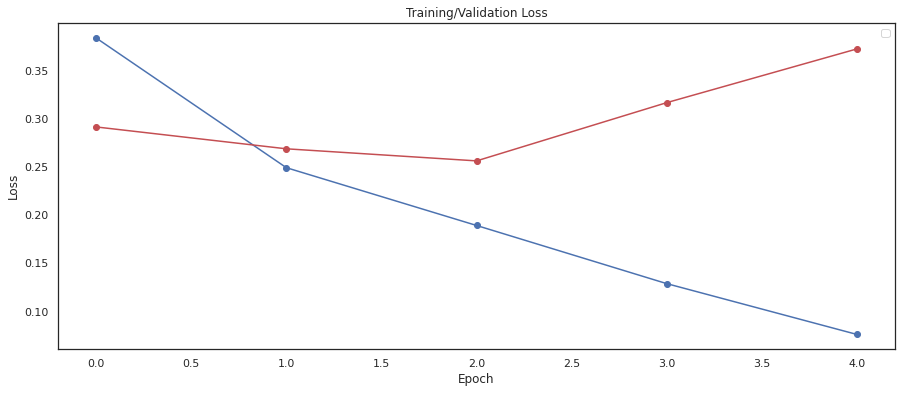

[2020-07-14 22:18:14,735][INFO] ## epoch: best, acc: 0.91533742, f1: 0.91051527, best_f1: 0.91051527



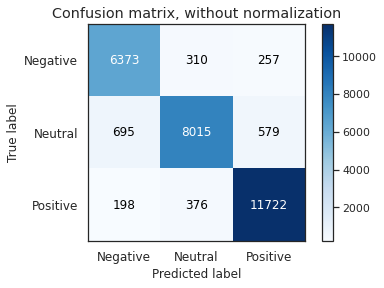

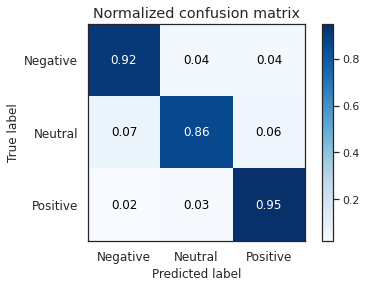

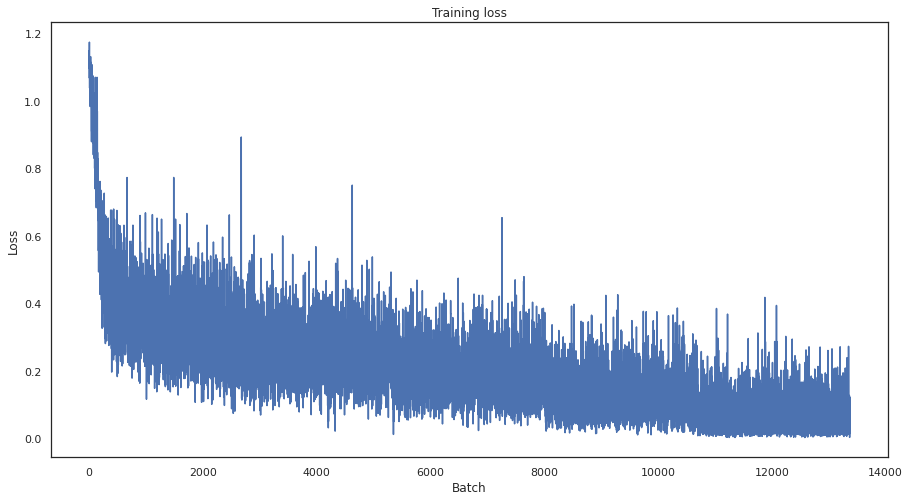

[2020-07-14 22:18:15,800][INFO] ## ================     fold 1        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-14 22:52:32,190][INFO] ## epoch: 1, train loss: 0.38220136, valid loss: 0.29254835, acc: 0.89830, f1: 0.892515, best_f1: 0.89251
, last lr: 0.000089
[2020-07-14 22:52:32,351][INFO] ## ================     epoch 2        ===============


[2020-07-14 23:26:53,729][INFO] ## epoch: 2, train loss: 0.24931717, valid loss: 0.27096307, acc: 0.90429, f1: 0.899468, best_f1: 0.89947
, last lr: 0.000067
[2020-07-14 23:26:53,910][INFO] ## ================     epoch 3        ===============


[2020-07-15 00:01:09,618][INFO] ## epoch: 3, train loss: 0.19010463, valid loss: 0.25833355, acc: 0.91351, f1: 0.908460, best_f1: 0.90846
, last lr: 0.000044
[2020-07-15 00:01:09,794][INFO] ## ================     epoch 4        ===============


[2020-07-15 00:35:39,106][INFO] ## epoch: 4, train loss: 0.12837378, valid loss: 0.30416575, acc: 0.91204, f1: 0.907002, best_f1: 0.90846
, last lr: 0.000022
[2020-07-15 00:35:39,271][INFO] ## ================     epoch 5        ===============


[2020-07-15 01:10:15,217][INFO] ## epoch: 5, train loss: 0.07482671, valid loss: 0.38936847, acc: 0.91008, f1: 0.904661, best_f1: 0.90846
, last lr: 0.000000


No handles with labels found to put in legend.


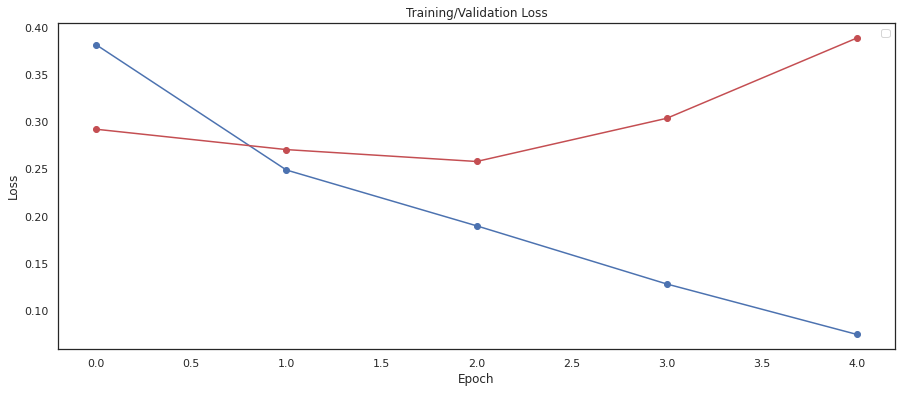

[2020-07-15 01:11:59,577][INFO] ## epoch: best, acc: 0.91351446, f1: 0.90845970, best_f1: 0.90845970



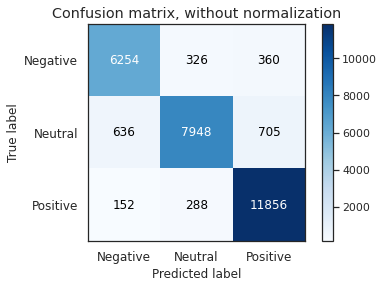

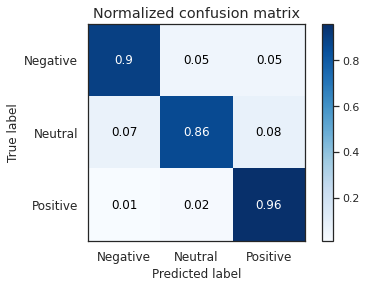

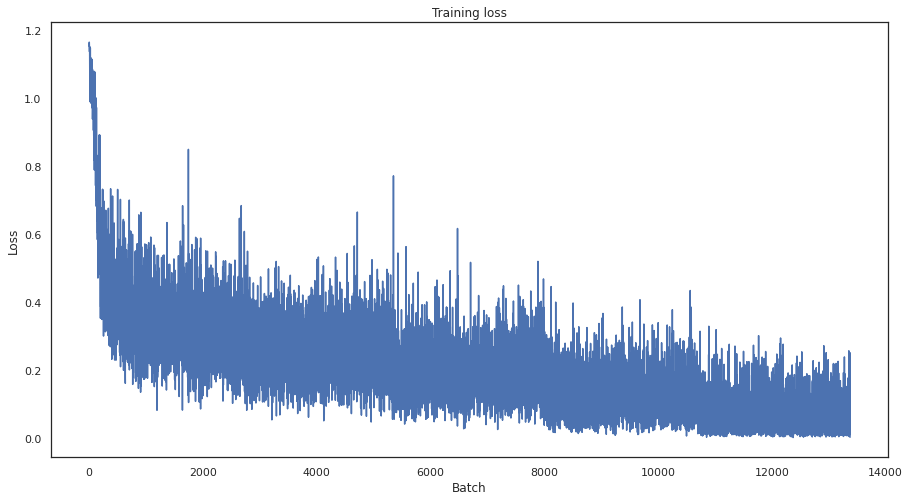

[2020-07-15 01:12:00,654][INFO] ## ================     fold 2        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [ ]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    train_bert(fold, train_indices, valid_indices)
    # Number of folds to iterrate
    if fold == 10:
        break


In [ ]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))

train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

# Testing
## Load Data

In [56]:
with open(tweet_dir + 'test_twits.json', 'r') as f:
    test_data = json.load(f)

## Twit Stream

In [57]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

## Prediction Function

In [65]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    text = preprocess(text)
    text_ids, pad_masks, segment_ids = bert_encoder(text)
    
    text_ids = torch.tensor(text_ids).unsqueeze(0)
    pad_masks = torch.tensor(pad_masks).unsqueeze(0)
    segment_ids = torch.tensor(segment_ids).unsqueeze(0)

    outputs = model(text_ids, pad_masks, segment_ids)[0].detach()    
    pred = F.softmax(outputs, dim=1)
    
    return pred

In [67]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(torch.load(output_dir + 'model_fold_0.dict'))
model.eval()
model.to("cpu")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [68]:
text = "Google is working on self driving cars, I'm bullish on $goog"
predict(text, model, vocab)

tensor([[6.4137e-05, 1.8802e-03, 9.9806e-01]])

## Apply the prediction function

In [80]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        if len(tokenizer.tokenize(preprocess(text))) < 10:
            continue
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'text': text, 'timestamp': twit['timestamp']}

In [81]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

In [82]:
i=0
for i in range(10):
    print(next(score_stream))
    i+=1

{'symbol': '$AMZN', 'score': tensor([[6.1494e-05, 1.6070e-03, 9.9833e-01]]), 'text': '$AMZN A lot of technical signs point to a short-term bottom in place for stocks (John Murphy)', 'timestamp': '2018-11-01T00:00:42Z'}
{'symbol': '$MU', 'score': tensor([[1.4381e-04, 9.9976e-01, 9.7787e-05]]), 'text': '@TraderLeibniz $NVDA Perhaps, no chance for $MU and $AMD till cycle &amp; trade war no longer concerns.... played these names for years. GL', 'timestamp': '2018-11-01T00:04:21Z'}
{'symbol': '$AAPL', 'score': tensor([[8.0178e-04, 9.9544e-01, 3.7575e-03]]), 'text': 'Bears tomorrow when $AAPL reports earnings and the rest of the market rips higher. $AMZN $SQ $IBM $IEP $AVGO $MSFT $TSLA $NFLX $GOOG $DIA', 'timestamp': '2018-11-01T00:07:32Z'}
{'symbol': '$AMZN', 'score': tensor([[8.0178e-04, 9.9544e-01, 3.7575e-03]]), 'text': 'Bears tomorrow when $AAPL reports earnings and the rest of the market rips higher. $AMZN $SQ $IBM $IEP $AVGO $MSFT $TSLA $NFLX $GOOG $DIA', 'timestamp': '2018-11-01T00:0

# Result

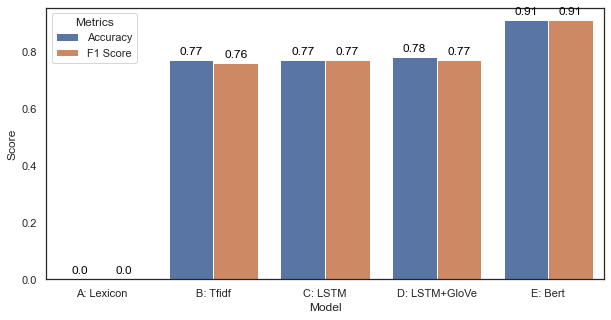

In [20]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='Model', y='Score', hue='Metrics', data=result_metrics)

for index, row in result_metrics.loc[result_metrics['Metrics']=='Accuracy'].iterrows():
    g.text(index-0.2, row.Score+0.02, row.Score, color='black', ha="center")
for index, row in result_metrics.loc[result_metrics['Metrics']=='F1 Score'].iterrows():
    g.text(index-4.8, row.Score+0.02, row.Score, color='black', ha="center")
plt.show()

# Save Data

In [ ]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'train_df')
save_data(train_df, 'train_tone_df')